In [1]:
import numpy as np
import os
from scipy.optimize import minimize
from scipy.stats import gamma, chi2

import numpy as np
import matplotlib.pyplot as plt

from iminuit import Minuit
from iminuit.util import make_func_code
from GVM_combination import combination, replace_labels

import json


In [2]:
input_folder = "input_files/"

In [6]:
comb = 'lhc'
key = 'LHCbJES'
eps = 0.01
uncertain_systematics = {key: eps}
#uncertain_systematics = {'LHCbJES': eps, 'CMSbHad':eps}
top_comb = combination(input_folder, uncertain_systematics, comb=comb)

syst_name = "new"
m_t_new = 174.5
stat_new = 0.4
syst_value = 0.5
uncertain_syst_value = 0.01
#top_comb.add_measurement(m_t_new, stat_new, syst_name, syst_value, uncertain_syst_value)

print(np.linalg.inv(top_comb.C_matrix_inv['LHCbJES']))
#print(top_comb.m_t)
#print(top_comb.stat)
#print(top_comb.syst)
#print(top_comb.V_Blue_inv)
#print(top_comb.uncertain_systematics)
#print(top_comb.Gamma_factors)
#print(top_comb.compute_FIM())


print(top_comb.fit_results)

[[1.   0.85]
 [0.85 1.  ]]
{'mu': 172.5134128802832, 'thetas': array([0.61066941, 0.39256115])}


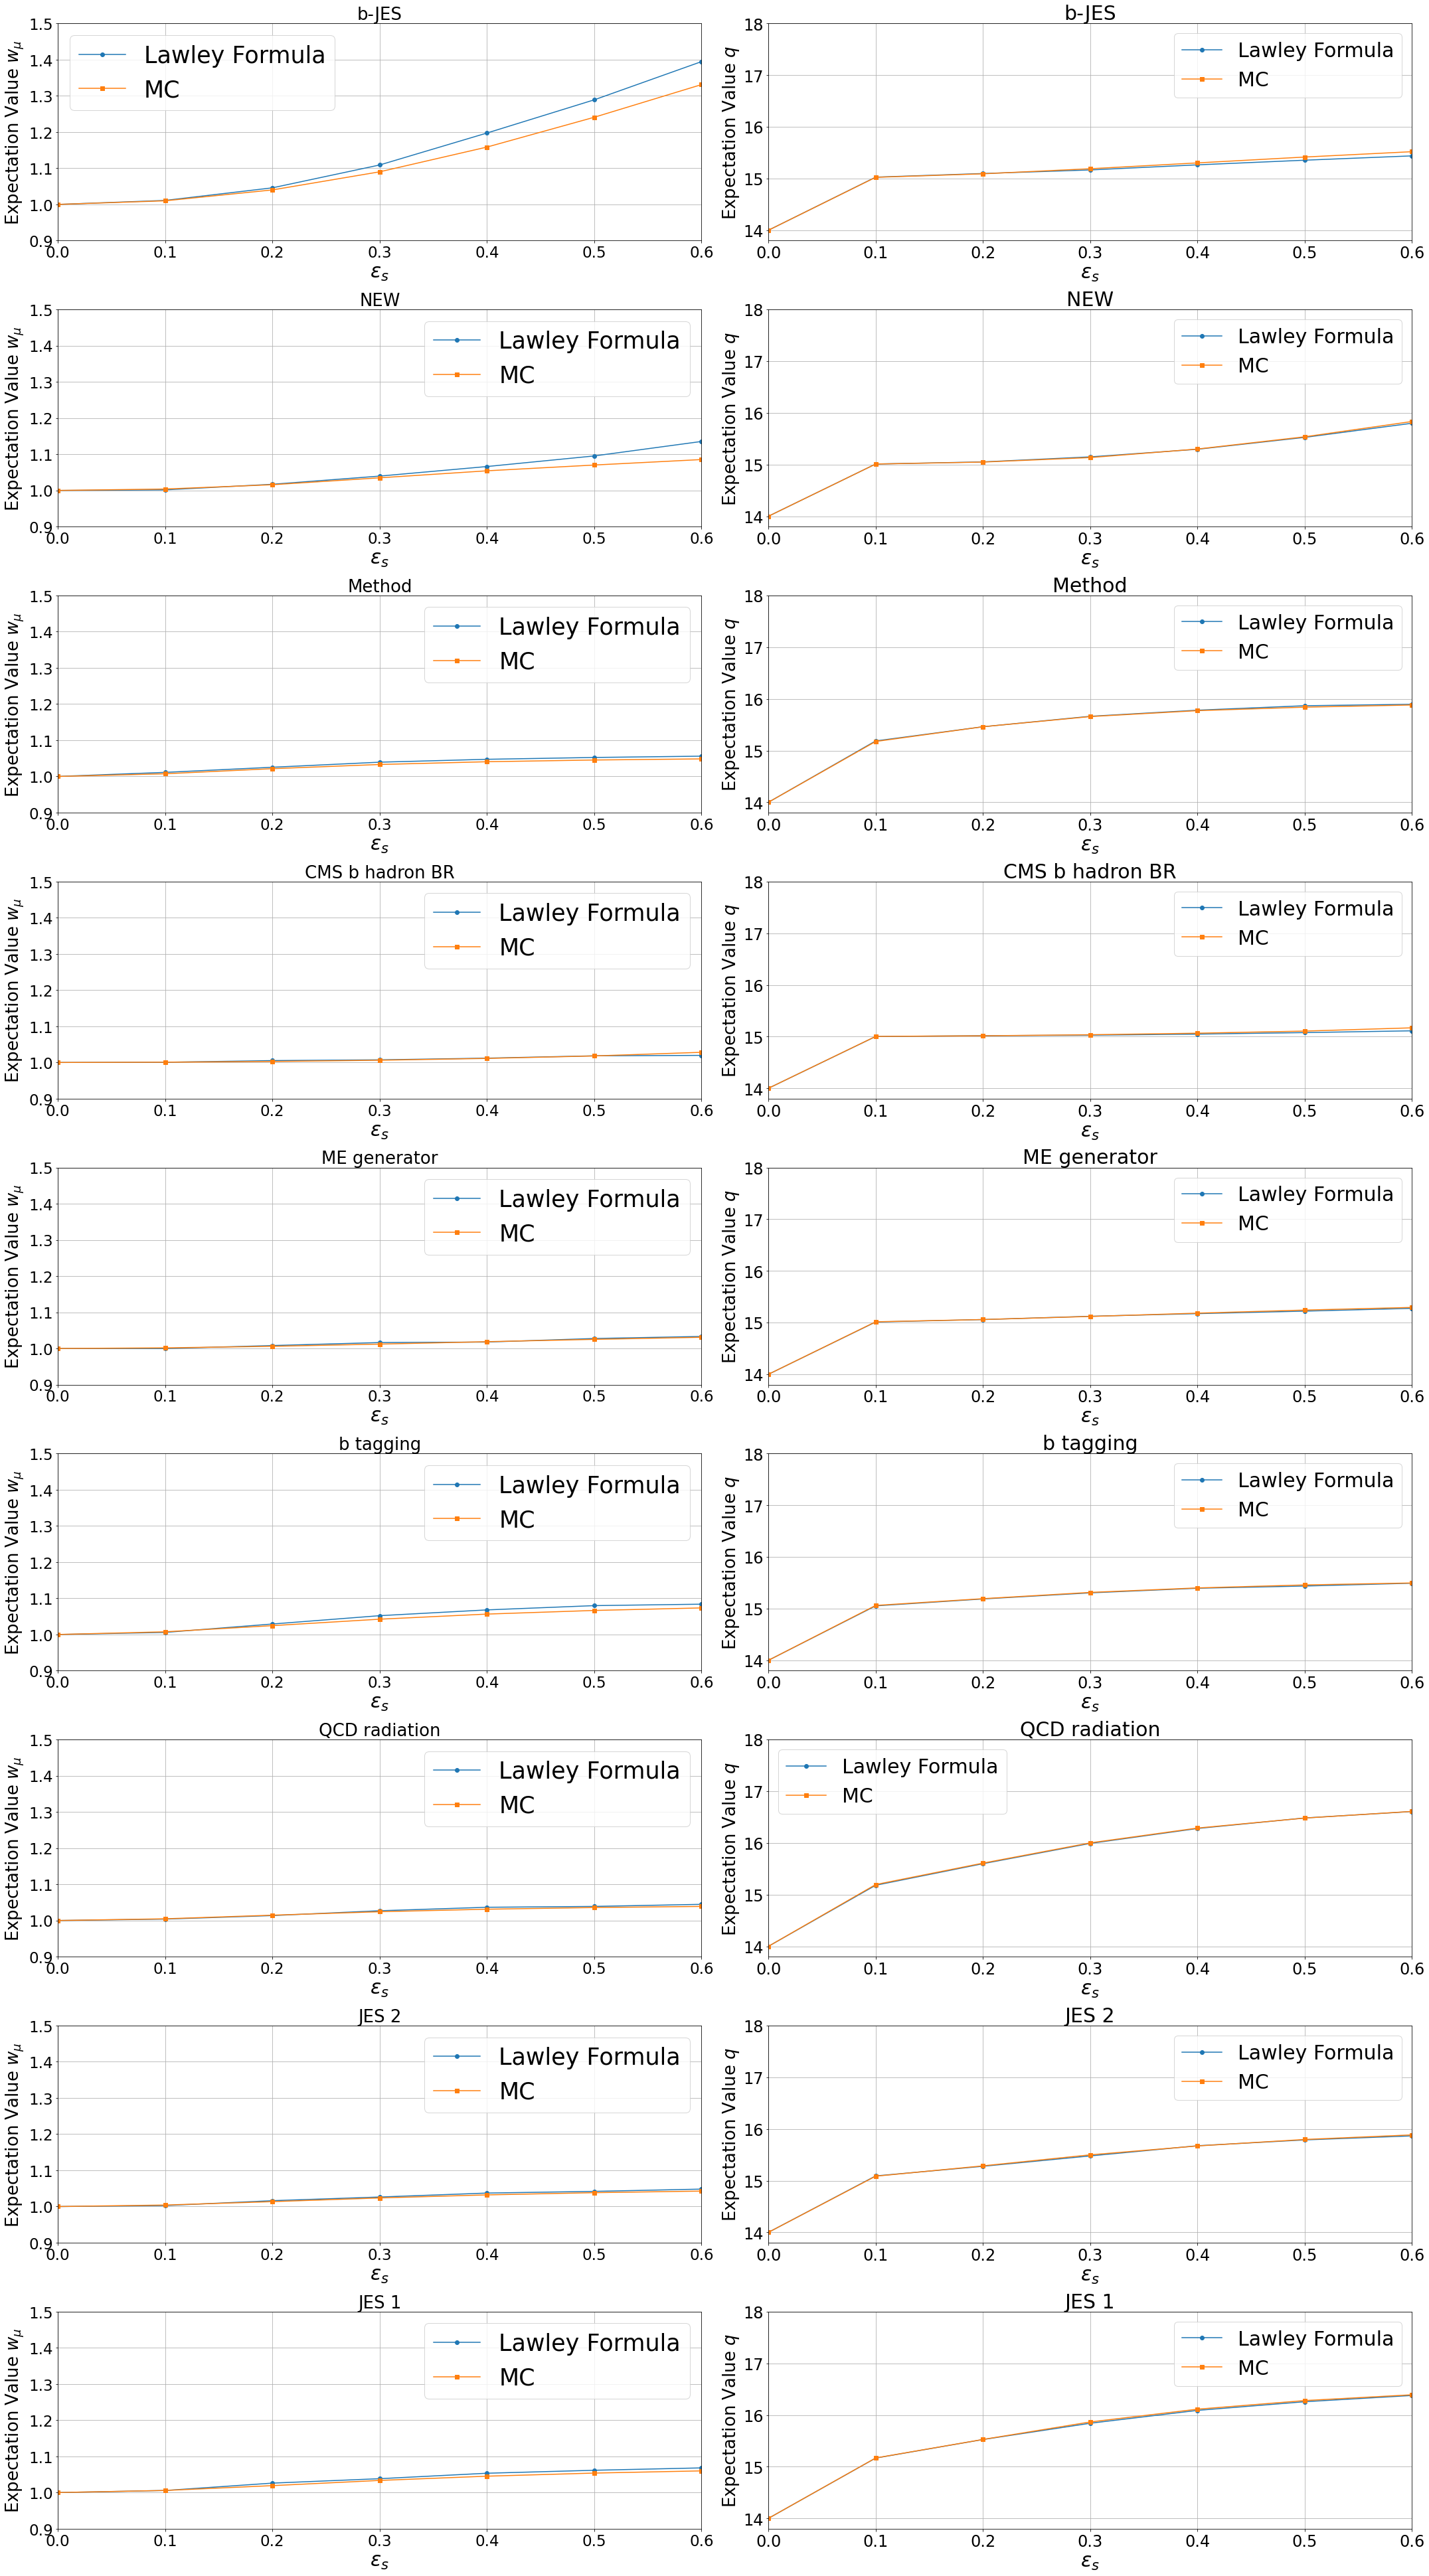

In [4]:
# Function to compute Bartlett corrections
# Map for replacing systematic keys with titles
label_replacements = {
    'new': "NEW",
    'LHCbJES': "b-JES",
    'btag': "b tagging",
    'ME': "ME generator",
    'LHCJES1': "JES 1",
    'LHCJES2': "JES 2",
    'method': "Method",
    'CMSbHad': "CMS b hadron BR",
    'LHCrad': "QCD radiation",
}

def compute_bartlett(eps, key):
    if key == 'new':
        uncertain_systematics = {}
        top_comb = combination(input_folder, uncertain_systematics, comb=comb)
        syst_name = "new"
        m_t_new = 174.5
        stat_new = 0.4
        syst_value = 0.45
        uncertain_syst_value = eps
        top_comb.add_measurement(m_t_new, stat_new, syst_name, syst_value, uncertain_syst_value)
    else:
        uncertain_systematics = {key: eps}
        top_comb = combination(input_folder, uncertain_systematics, comb=comb)
        syst_name = "new"
        m_t_new = 174.5
        stat_new = 0.2
        syst_value = 0.45
        uncertain_syst_value = 0.01
        top_comb.add_measurement(m_t_new, stat_new, syst_name, syst_value, uncertain_syst_value)
    _, lik_ratio, q_value = top_comb.compute_b_lawley()
    return lik_ratio, q_value

# Load the JSON file with Bartlett corrections
with open('bartlett_files/new1_bartlett/summary_results_bias_sigma.json', 'r') as file:
    data = json.load(file)

# Configuration for the computations
input_folder = "input_files/"
comb = 'lhc'
N = 15

# Prepare for the grid of subplots
n_keys = len(data.keys())
fig, axes = plt.subplots(n_keys, 2, figsize=(30, 6 * n_keys))  # Increased horizontal space further
fig.subplots_adjust(hspace=0.5, wspace=0.6)  # Add more space between left and right plots

# Loop through each systematic key
for i, (key, eps_values) in enumerate(data.items()):
    eps_list = [0]  # Start with the default point at eps=0
    bartlett_lik_ratios = [1]  # Default value for lik_ratio at eps=0
    bartlett_qs = [N - 1]  # Default value for q_value at eps=0 (N-1, where N=15)
    computed_lik_ratios = [1]  # Assume the computed default is also the theoretical default
    computed_q_values = [N - 1]  # Same assumption for q_value

    # Sort eps values and include them for consistent plotting order
    sorted_eps = sorted(eps_values, key=lambda x: float(x))
    for eps in sorted_eps:
        stats = eps_values[eps]
        eps_float = float(eps)
        eps_list.append(eps_float)
        bartlett_lik_ratios.append(stats['lik_ratio'])
        bartlett_qs.append(stats['q_value'])

        # Compute actual bias using the provided function
        lik_ratio, q_value = compute_bartlett(eps_float, key)
        computed_lik_ratios.append(lik_ratio)
        computed_q_values.append(q_value)

    # Plot likelihood ratio on the left
    ax_lik = axes[i, 0] if n_keys > 1 else axes[0]
    ax_lik.plot(eps_list, bartlett_lik_ratios, 'o-', label='Lawley Formula')
    ax_lik.plot(eps_list, computed_lik_ratios, 's-', label='MC')
    ax_lik.set_xlabel('$ε_s$', fontsize=30)
    ax_lik.set_ylabel('Expectation Value $w_\mu$', fontsize=26)
    ax_lik.set_title(label_replacements.get(key, key),  fontsize=26)
    ax_lik.set_ylim((0.9, 1.5))
    ax_lik.set_xlim((0, 0.6))
    ax_lik.grid(True)
    ax_lik.legend(fontsize=35)
    ax_lik.tick_params(axis='both', which='major', labelsize=23)

    # Plot Q value on the right
    ax_q = axes[i, 1] if n_keys > 1 else axes[1]
    ax_q.plot(eps_list, bartlett_qs, 'o-', label='Lawley Formula')
    ax_q.plot(eps_list, computed_q_values, 's-', label='MC')
    ax_q.set_title(label_replacements.get(key, key),  fontsize=30)
    ax_q.set_xlabel('$ε_s$', fontsize=30)
    ax_q.set_ylabel('Expectation Value $q$', fontsize=26)
    ax_q.set_ylim((13.8, 18))
    ax_q.set_xlim((0, 0.6))
    ax_q.grid(True)
    ax_q.legend(fontsize=30)
    ax_q.tick_params(axis='both', which='major', labelsize=24)

# Save and show the large figure
plt.tight_layout()
#plt.savefig('all_comparisons_new2.pdf')
plt.show()

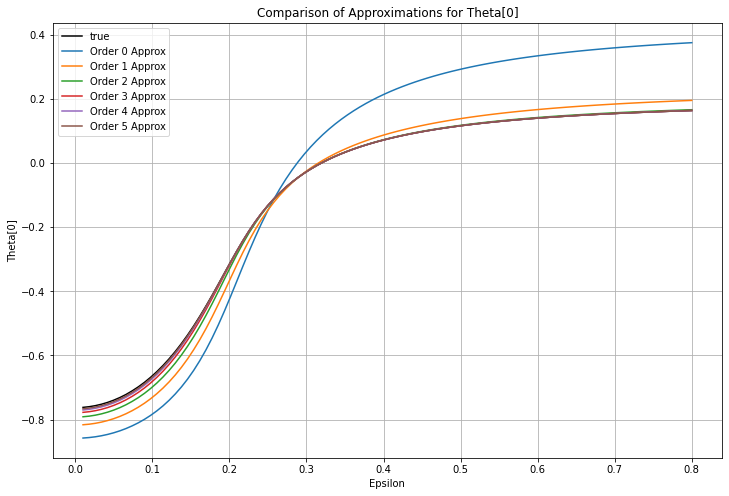

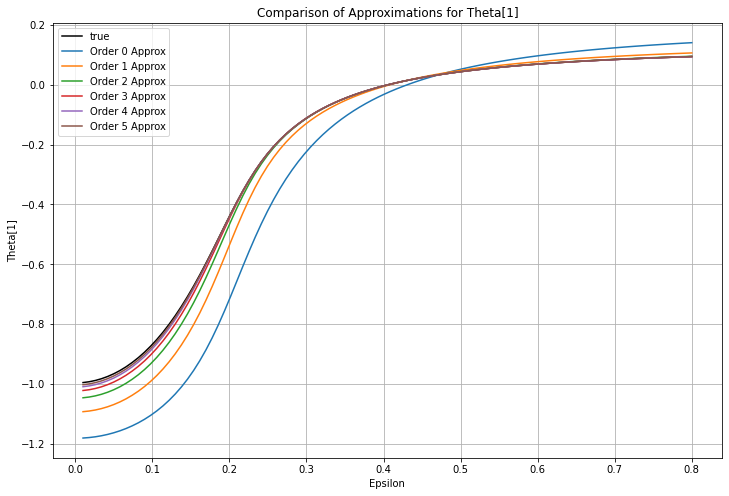

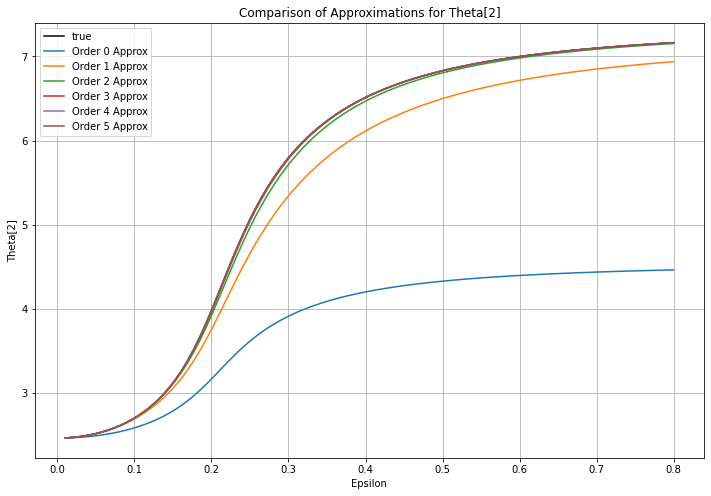

In [26]:
eps_min = 0.01
eps_max = 0.8
num_eps = 100
epsilons = np.linspace(eps_min, eps_max, num_eps)

comb = 'lhc'
key = 'LHCbJES'
syst_name = "new"
m_t_new = 174.5
stat_new = 0.2
syst_value = 0.25
eps = 0.01
uncertain_syst_value = eps
#uncertain_systematics = {'LHCbJES': eps, 'btag': eps, 'ME':eps, 'LHCJES1':eps, 'LHCJES2':eps, 'method':eps, 'CMSbHad':eps, 'LHCrad':eps}
#uncertain_systematics = {'LHCbJES': eps}
top_comb = combination(input_folder, uncertain_systematics, comb=comb)
top_comb.add_measurement(m_t_new, stat_new, syst_name, syst_value, uncertain_syst_value)
    
N = len(top_comb.fit_results['thetas'])

thetas_true = np.zeros((num_eps, N))
thetas_mle_0 = np.zeros((num_eps, N))
thetas_mle_1 = np.zeros((num_eps, N))
thetas_mle_2 = np.zeros((num_eps, N))
thetas_mle_3 = np.zeros((num_eps, N))
thetas_mle_4 = np.zeros((num_eps, N))
thetas_mle_5 = np.zeros((num_eps, N))


for eps_index, eps in enumerate(epsilons):
    #uncertain_systematics = {'LHCbJES': eps}
    top_comb = combination(input_folder, uncertain_systematics, comb=comb)
    uncertain_syst_value = eps
    top_comb.add_measurement(m_t_new, stat_new, syst_name, syst_value, uncertain_syst_value)
    
    theta_true = top_comb.fit_results['thetas']
    mu_true = top_comb.fit_results['mu']
    thetas_true[eps_index, :] = theta_true
    
    # Compute theta_mle_0
    theta_mle_0 = top_comb.compute_theta_mle_at_order(mu_true, max_order=0)
    thetas_mle_0[eps_index, :] = theta_mle_0
    
    theta_mle_1 = top_comb.compute_theta_mle_at_order(mu_true, max_order=1)
    thetas_mle_1[eps_index, :] = theta_mle_1
    
    theta_mle_2 = top_comb.compute_theta_mle_at_order(mu_true, max_order=2)
    thetas_mle_2[eps_index, :] = theta_mle_2
    
    theta_mle_3 = top_comb.compute_theta_mle_at_order(mu_true, max_order=3)
    thetas_mle_3[eps_index, :] = theta_mle_3
    
    theta_mle_4 = top_comb.compute_theta_mle_at_order(mu_true, max_order=4)
    thetas_mle_4[eps_index, :] = theta_mle_4
    
    theta_mle_5 = top_comb.compute_theta_mle_at_order(mu_true, max_order=5)
    thetas_mle_5[eps_index, :] = theta_mle_5

for i in range(N):
    plt.figure(figsize=(12, 8))
    plt.plot(epsilons, thetas_true[:, i], label='true', color = 'black')
    plt.plot(epsilons, thetas_mle_0[:, i], label='Order 0 Approx')
    plt.plot(epsilons, thetas_mle_1[:, i], label='Order 1 Approx')
    plt.plot(epsilons, thetas_mle_2[:, i], label='Order 2 Approx')
    plt.plot(epsilons, thetas_mle_3[:, i], label='Order 3 Approx')
    plt.plot(epsilons, thetas_mle_4[:, i], label='Order 4 Approx')
    plt.plot(epsilons, thetas_mle_5[:, i], label='Order 5 Approx')
    
    plt.xlabel('Epsilon')
    plt.ylabel(f'Theta[{i}]')
    plt.grid(True)
    plt.title(f'Comparison of Approximations for Theta[{i}]')
    plt.legend()
    plt.show()

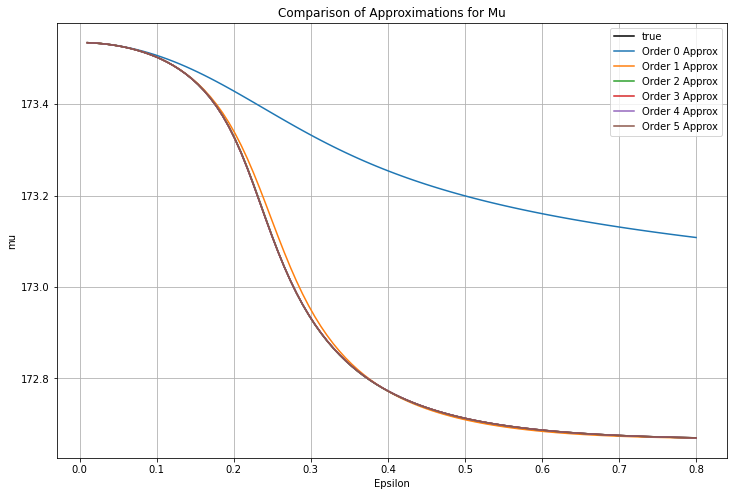

In [25]:
eps_min = 0.01
eps_max = 0.8
num_eps = 100
epsilons = np.linspace(eps_min, eps_max, num_eps)

comb = 'lhc'
key = 'LHCbJES'
syst_name = "new"
m_t_new = 174.5
stat_new = 0.2
syst_value = 0.25
eps = 0.01
uncertain_syst_value = eps
uncertain_systematics = {key: eps}
#uncertain_systematics = {'LHCbJES': eps, 'btag': eps, 'ME':eps, 'LHCJES1':eps, 'LHCJES2':eps, 'method':eps, 'CMSbHad':eps, 'LHCrad':eps}
top_comb = combination(input_folder, uncertain_systematics, comb=comb)
top_comb.add_measurement(m_t_new, stat_new, syst_name, syst_value, uncertain_syst_value)
    
N = len(top_comb.fit_results['thetas'])

mu_true = np.zeros(num_eps)
mu_mle_0 = np.zeros(num_eps)
mu_mle_1 = np.zeros(num_eps)
mu_mle_2 = np.zeros(num_eps)
mu_mle_3 = np.zeros(num_eps)
mu_mle_4 = np.zeros(num_eps)
mu_mle_5 = np.zeros(num_eps)


for eps_index, eps in enumerate(epsilons):
    uncertain_systematics = {key: eps}
    #uncertain_systematics = {'LHCbJES': eps, 'btag': eps, 'ME':eps, 'LHCJES1':eps, 'LHCJES2':eps, 'method':eps, 'CMSbHad':eps, 'LHCrad':eps}
    #top_comb = combination(input_folder, uncertain_systematics, comb=comb)
    top_comb = combination(input_folder, uncertain_systematics, comb=comb)
    uncertain_syst_value = eps
    top_comb.add_measurement(m_t_new, stat_new, syst_name, syst_value, uncertain_syst_value)
    
    mu_true_value = top_comb.fit_results['mu']
    mu_true[eps_index] = mu_true_value
    
    # Compute theta_mle_0
    mu_mle_0_value = top_comb.compute_mu_mle_at_order(max_order=0)
    mu_mle_0[eps_index] = mu_mle_0_value
    
    mu_mle_1_value = top_comb.compute_mu_mle_at_order(max_order=1)
    mu_mle_1[eps_index] = mu_mle_1_value
    
    mu_mle_2_value = top_comb.compute_mu_mle_at_order(max_order=2)
    mu_mle_2[eps_index] = mu_mle_2_value
    
    mu_mle_3_value = top_comb.compute_mu_mle_at_order(max_order=3)
    mu_mle_3[eps_index] = mu_mle_3_value
    
    mu_mle_4_value = top_comb.compute_mu_mle_at_order(max_order=4)
    mu_mle_4[eps_index] =mu_mle_4_value
    
    mu_mle_5_value = top_comb.compute_mu_mle_at_order(max_order=5)
    mu_mle_5[eps_index] = mu_mle_5_value

plt.figure(figsize=(12, 8))
plt.plot(epsilons, mu_true[:], label='true', color = 'black')
plt.plot(epsilons, mu_mle_0[:], label='Order 0 Approx')
plt.plot(epsilons, mu_mle_1[:], label='Order 1 Approx')
plt.plot(epsilons, mu_mle_2[:], label='Order 2 Approx')
plt.plot(epsilons, mu_mle_3[:], label='Order 3 Approx')
plt.plot(epsilons, mu_mle_4[:], label='Order 4 Approx')
plt.plot(epsilons, mu_mle_5[:], label='Order 5 Approx')

plt.xlabel('Epsilon')
plt.ylabel(f'mu')
plt.grid(True)
plt.title(f'Comparison of Approximations for Mu')
plt.legend()
plt.show()